Let's begin by importing some important modules.

In [5]:
import matplotlib.pyplot as plt
%matplotlib widget
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import numpy as np
import astropy.units as u
from astropy.wcs import WCS
from pvextractor import extract_pv_slice, Path
from helpers import get_uJy_cube, get_pixel

# Make Path Function
This function creates a pvextractor Path object given some start point, end point, center, and length.

In [2]:
def make_path(x_start, y_start, x_end, y_end, center, segment_length=6):
    line_vec = np.array([x_end - x_start, y_end - y_start])
    line_length = np.linalg.norm(line_vec)
    unit_vec = line_vec / line_length
    perp_vec = np.array([-unit_vec[1], unit_vec[0]])
    half_len = segment_length / 2
    x_c = center[0]
    y_c = center[1]
    
    start_pt = np.array([x_c, y_c]) - perp_vec * half_len
    end_pt = np.array([x_c, y_c]) + perp_vec * half_len

    verts = [start_pt, end_pt]
    path = Path(verts, width=3)
    return path

# PV Diagram Plotting
This function takes care of plotting PV diagrams.

In [3]:
def plot_pv_diagram(fits_file, center, moment0_width, fit_width, distance=140*u.pc):
    # lambda_obs = v_to_wavelen(center, 29.8 * u.km/u.s)
    # print(f"Lambda_obs: {lambda_obs:.5f}")
    lambda_obs = center
    
    cube = get_uJy_cube(fits_file)
    delta = (fit_width / 2)
    subcube = cube.spectral_slab(lambda_obs-delta, lambda_obs+delta)
    vcube = subcube.with_spectral_unit(u.km/u.s, velocity_convention='optical',rest_value=lambda_obs) # lambda_obs for v_LSR
    
    centers = [(25.26613227, 33.59679364), (26.13168151, 38.79008904), (27.0120717, 44.07243022)]
    ra = 69.896675 * u.degree
    dec = 25.69561666667 * u.degree
    x1, y1 = get_pixel(cube, ra, dec)
    x1 -= 2
    y1 -= 1 # NOTE: Not real
    paths = [make_path(x1, y1, 28, 50, centers[i], 6) for i in range(3)]
    pvdiagrams = [extract_pv_slice(cube=vcube, path=paths[i], spacing=0.5) for i in range(3)]   

    fig = plt.figure(figsize=(13, 4))
    gs = GridSpec(1, 5, width_ratios=[2, 1, 1, 1, 0.05], wspace=0.15)

    # Flux density map (leftmost subplot)
    ax = fig.add_subplot(gs[0, 0], projection=vcube.wcs.celestial)
    slice = fits.open("../fits/slice2d.fits")[0].data
    ax.imshow(np.log10(slice), origin='lower', cmap='inferno', vmin=0)
    for i in range(3):
        paths[i].show_on_axis(ax, spacing=0.5, edgecolor="cyan", linewidth=0.75)
    ax.plot(x1, y1, marker='*', color='black')
    ax.set_facecolor('black')
    ax.set_xlabel(f"RA", fontsize=12)
    ax.set_ylabel(f"Dec", fontsize=12)

    # PV diagrams
    for i in range(3):
        ax = fig.add_subplot(gs[0, i+1], projection=WCS(pvdiagrams[i].header))
        pv_data = pvdiagrams[i].data
        im = ax.imshow(np.log10(pv_data), vmax=2)

        # Peak velocity plotting
        x_pix = np.arange(pv_data.shape[1])
        y_pix = np.argmax(pv_data, axis=0)
        world_coords = WCS(pvdiagrams[i].header).pixel_to_world_values(x_pix, y_pix)
        offsets = world_coords[0] * 3600 * u.arcsec
        velocities = world_coords[1] / 1000 * u.km/u.s
        px, py = ax.wcs.world_to_pixel(offsets, velocities)
        ax.plot(px, py, 'o', color='white', markersize=3)

        ax0 = ax.coords[0]
        ax0.set_format_unit(u.arcsec)
        ax.coords[0].set_major_formatter('x.x')
        ax1 = ax.coords[1]
        ax1.set_format_unit(u.km / u.s)

        ax.set_ylabel("Velocity [km/s]", fontsize=12)
        if i != 0:
            ax.tick_params(axis='y', labelleft=False)
        ax.set_xlabel("Offset (\")", fontsize=12) 
        ax.set_aspect(0.8)

    # Colorbar
    cax = fig.add_subplot(gs[0, 4])
    cb = plt.colorbar(mappable=im, cax=cax)
    cb.set_label('$\log_{10} F_\lambda \, (\mu Jy)$', fontsize=12)

    # Global title
    # fig.suptitle(f"PV Diagrams ($\lambda = $ {center}, closest to furthest)", fontsize=12)
    fig.subplots_adjust(top=0.88, bottom=0.15)
    plt.show()

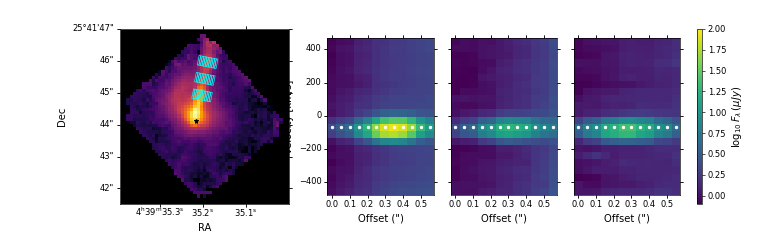

In [7]:
plt.rcParams['figure.dpi'] = 60 # Changes widget size
plot_pv_diagram('../fits/4s3d.fits', 1.644*u.um, moment0_width=0.0015*u.um, fit_width=0.005*u.um)